# Introduction

In this notebook, we’ll explore how to train a lightweight NanoGPT on the Tiny Stories dataset. NanoGPT, developed by Andrej Karpathy, is a simplified variant of GPT designed for simplicity and speed. Our goal is to generate creative and coherent text based on the input data. I will also use Wandb library to track the experiments on the model.

# Import Libraries

In [ ]:
# Clone the NanoGPT
!git clone https://github.com/karpathy/nanoGPT.git
!pip install tiktoken

fatal: destination path 'nanoGPT' already exists and is not an empty directory.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import nanoGPT.model as GPT
import wandb
import os

In [ ]:
# from kaggle_secrets import UserSecretsClient
# # Load API keys https://www.kaggle.com/discussions/product-feedback/114053
# secret_label = "WANDB_API_KEY"
my_secret = "c2e3619f245387906ce0bd58733dc79534a116bc"

In [ ]:
class GPTConfig: # Model config from NanoGPT
    block_size: int = 256
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 14
    n_head: int = 8
    n_embd: int = 384
    dropout: float = 0.15
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

config = GPTConfig

In [ ]:
wandb_config = {k:v for k,v in vars(config).items() if not callable(getattr(config, k)) and not k.startswith("__")} # Creating Wandb hyperparameters config for tracking experiements
wandb_config

{'block_size': 256,
 'vocab_size': 50304,
 'n_layer': 14,
 'n_head': 8,
 'n_embd': 384,
 'dropout': 0.15,
 'bias': True}

In [ ]:
wandb.login(key=my_secret)

# Tiny Stories datasets and preprocessing

TinyStories, a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4. We show that TinyStories can be used to train and evaluate LMs that are much smaller than the state-of-the-art models (below 10 million total parameters)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [ ]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

# Training

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# Training Config

learning_rate = 3e-4
max_iters = 26000
warmup_steps = 2000
min_lr = 1e-5
eval_iters = 100
batch_size = 12
block_size = 128

gradient_accumulation_steps = 20

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

nanoGPT = GPT.GPT(config)
optimizer =  torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-9,weight_decay=0.01)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 44.16M


<ipython-input-11-58c276a4f6b4>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
wandb.init(project="nanogpt-tinystories", name="nanoGPT-sml-longer", config=wandb_config)

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        wandb.log({
                "epoch": epoch,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": optimizer.param_groups[0]['lr']
            })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

    X,y = get_batch("train")

    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), 1)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/26000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 100: train loss 9.7087, val loss 9.7197
The current learning rate: 0.0001
Epoch 200: train loss 9.2666, val loss 9.2696
The current learning rate: 0.0001
Epoch 300: train loss 8.8679, val loss 8.8732
The current learning rate: 0.0001
Epoch 400: train loss 8.4205, val loss 8.4200
The current learning rate: 0.0001
Epoch 500: train loss 7.9736, val loss 7.9753
The current learning rate: 0.0001
Epoch 600: train loss 7.5277, val loss 7.5131
The current learning rate: 0.0002
Epoch 700: train loss 7.0763, val loss 7.0664
The current learning rate: 0.0002
Epoch 800: train loss 6.6463, val loss 6.6525
The current learning rate: 0.0002
Epoch 900: train loss 6.2751, val loss 6.2554
The current learning rate: 0.0002
Epoch 1000: train loss 5.9083, val loss 5.9188
The current learning rate: 0.0002
Epoch 1100: train loss 5.6174, val loss 5.6077
The current learning rate: 0.0002
Epoch 1200: train loss 5.3513, val loss 5.3403
The current learning rate: 0.0002
Epoch 1300: train loss 5.1465, val lo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2000: train loss 4.3142, val loss 4.2966
The current learning rate: 0.0003
Epoch 2100: train loss 4.2512, val loss 4.2592
The current learning rate: 0.0003
Epoch 2200: train loss 4.1801, val loss 4.1640
The current learning rate: 0.0003
Epoch 2300: train loss 4.1003, val loss 4.1284
The current learning rate: 0.0003
Epoch 2400: train loss 4.0573, val loss 4.0619
The current learning rate: 0.0003
Epoch 2500: train loss 4.0418, val loss 4.0193
The current learning rate: 0.0003
Epoch 2600: train loss 3.9737, val loss 3.9647
The current learning rate: 0.0003
Epoch 2700: train loss 3.9020, val loss 3.9028
The current learning rate: 0.0003
Epoch 2800: train loss 3.9044, val loss 3.8632
The current learning rate: 0.0003
Epoch 2900: train loss 3.8508, val loss 3.8573
The current learning rate: 0.0003
Epoch 3000: train loss 3.8136, val loss 3.7920
The current learning rate: 0.0003
Epoch 3100: train loss 3.7510, val loss 3.7603
The current learning rate: 0.0003
Epoch 3200: train loss 3.732

epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
lr,▄▄▇▇▇█████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
train/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25900
lr,1e-05
train/loss,2.33793
val/loss,2.33124


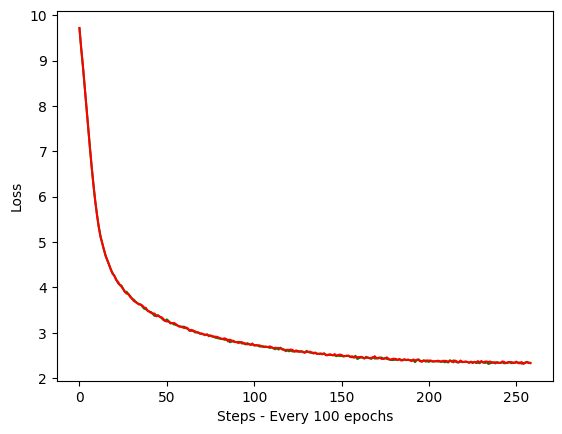

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]
plt.plot(train_loss_list_converted, 'g', validation_loss_list_converted, 'r')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.show()

# Inference

In [ ]:
# Load the model
nanoGPT = GPT.GPT(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))  # Load best model states

# Set sampling parameters
top_k = 50  # Keep only the top k most probable tokens
top_p = 0.95  # Keep only the top p cumulative probability mass
temperature = 0.9  # Adjusts randomness; lower is more conservative, higher adds diversity

# Encode initial context
sentence = "the sun is bright today, "
context = torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(0).to(device)


# Generate tokens with top-k, top-p, and temperature adjustments
def sample_with_top_k_top_p(logits, top_k=50, top_p=0.9, temperature=1.0):
    # Apply temperature scaling
    logits = logits / temperature

    # Top-k filtering
    if top_k > 0:
        values, indices = torch.topk(logits, top_k)
        min_values = values[:, -1].unsqueeze(-1)
        logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

    # Top-p (nucleus) filtering
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above top_p
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift tokens to the right to keep the first token above the threshold
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = False

        # Set removed logits to negative infinity
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[0, indices_to_remove] = float('-inf')

    # Sample from the filtered distribution
    probs = F.softmax(logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return next_token


number of parameters: 44.16M


<ipython-input-22-e6fc4e69fc6f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)

In [ ]:
def generate_text(model, context, max_length=200):
    generated = context
    for _ in range(max_length):
        # Ensure we only extract logits from the output
        output = model(generated)
        if isinstance(output, tuple):
            logits = output[0]  # Take the first element if it's a tuple
        else:
            logits = output  # Use directly if not a tuple

        logits = logits[:, -1, :]  # Get logits for the last token
        next_token = sample_with_top_k_top_p(logits, top_k=top_k, top_p=top_p, temperature=temperature)
        generated = torch.cat((generated, next_token), dim=1)

        # Stop if the model predicts the end of the sequence (optional)
        if next_token.item() == enc.encode_ordinary("<|endoftext|>"):
            break

    return generated


# Generate and decode the text
y = generate_text(nanoGPT, context)
print(enc.decode(y.squeeze().tolist()))

the sun is bright today, 
The mommy smiled and said, "Yes, it is. Let's go on an adventure." 
So they went to a different adventure. They walked up and walked until they got there. 

When they arrived, they saw a big, red flower. It was green, so they could go inside. 
"Wow, look at that little flower," said Mommy. 
"It is so pretty," said Mommy. 
"Yes, it's so pretty," said Mommy, "I love the flower. And you're welcome!" 
Tommy looked at the flower with her, but it was all too cold, and she couldn't feel sad. He wanted to eat his friends. He wanted to get to come home and get sick.

" in the little one more. I got on, but it was happy again. That way home, and soon, he knew that was still needed to leave. He promised the sun


In [ ]:
import torch
import torch.nn.functional as F  # For softmax operations

# Initialize the model and device
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"

# Load the model's parameters
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
nanoGPT.eval()

<ipython-input-26-30c35984214f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.15, inplace=False)
    (h): ModuleList(
      (0-13): 14 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=True)
          (c_proj): Linear(in_features=384, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.15, inplace=False)
          (resid_dropout): Dropout(p=0.15, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=50304, bias=False)
)

In [ ]:


def generate_with_params(
    model,
    prompt,
    max_tokens=200,
    temperature=0.8,
    top_k=40,
    top_p=0.92,
    repetition_penalty=1.2
):
    # Encode the prompt into tokens and move to the appropriate device
    context = torch.tensor(enc.encode_ordinary(prompt), dtype=torch.long).unsqueeze(0).to(device)

    generated_tokens = []
    past_tokens = context.squeeze().tolist()

    with torch.no_grad():
        for _ in range(max_tokens):
            # Forward pass through the model to get logits
            logits, _ = model(context)
            logits = logits[:, -1, :] / temperature  # Scale by temperature

            # Apply repetition penalty
            for prev_token in set(past_tokens):
                logits[0, prev_token] /= repetition_penalty

            # Apply top-k filtering
            if top_k > 0:
                values, _ = torch.topk(logits, top_k)
                min_values = values[:, -1].unsqueeze(-1)
                logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

            # Apply top-p (nucleus) filtering
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above top_p
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0  # Keep at least one token

                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits = torch.where(indices_to_remove, torch.full_like(logits, float('-inf')), logits)

            # Sample the next token from the distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Update context and past tokens
            context = torch.cat([context, next_token], dim=1)
            past_tokens.append(next_token.item())

            # Optionally stop if an end token is generated
            # if next_token.item() == end_token_id:
            #     break

    # Decode the generated tokens into text
    generated_text = enc.decode(context.squeeze().tolist())
    return generated_text


In [ ]:
prompt = "Once upon a time there was a pumpkin."
generated_text = generate_with_params(nanoGPT, prompt, max_tokens=200)
print(generated_text)

NameError: name 'generate_with_params' is not defined

In [ ]:
from google.colab import runtime
runtime.unassign()